<a target="_blank" href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/ML_day2/2_3_SVM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML_Day2_3

###  Reference

https://datascienceschool.net/

Hands on machine learning

## 1. Support Vector Machine

### 1)  Basic SVM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

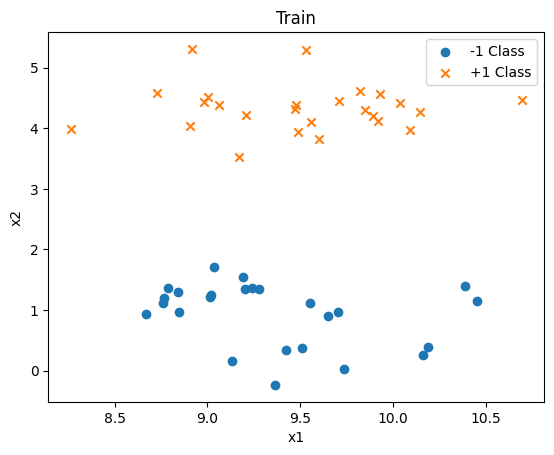

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.5, random_state=4) #center의 개수만큼 정규분포를 만든다 (x->data, y->label(0,1))
y = 2 * y - 1

plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', label="-1 Class")
plt.scatter(X[y == +1, 0], X[y == +1, 1], marker='x', label="+1 Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Train")
plt.show()

In [4]:
from sklearn.svm import SVC #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
model = SVC(kernel='linear', C=1e10).fit(X, y) #(X,y)에 대해서 학습

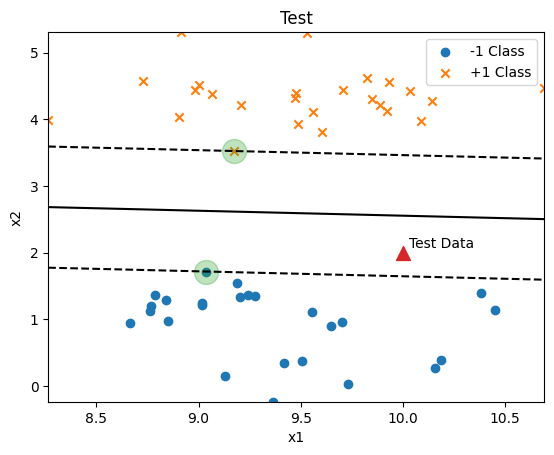

In [5]:
xmin = X[:, 0].min()
xmax = X[:, 0].max()
ymin = X[:, 1].min()
ymax = X[:, 1].max()
xx = np.linspace(xmin, xmax, 10)
yy = np.linspace(ymin, ymax, 10)
X1, X2 = np.meshgrid(xx, yy)

Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1): # 다차원 배열에 대한 enumerate()
    x1 = val
    x2 = X2[i, j]
    p = model.decision_function([[x1, x2]])
    Z[i, j] = p[0] # 지금은 label이 두 종류이기 때문에 decision boundary가 한 개만 존재
levels = [-1, 0, 1]
linestyles = ['dashed', 'solid', 'dashed']
plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', label="-1 Class")
plt.scatter(X[y == +1, 0], X[y == +1, 1], marker='x', label="+1 Class")
plt.contour(X1, X2, Z, levels, colors='k', linestyles=linestyles)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, alpha=0.3) # 서포트 벡터를 강조

x_new = [10, 2]
plt.scatter(x_new[0], x_new[1], marker='^', s=100)
plt.text(x_new[0] + 0.03, x_new[1] + 0.08, "Test Data")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.title("Test")
plt.show()

In [6]:
model.coef_.dot(x_new) + model.intercept_ #새로운 점은 -1에 가깝다

array([-0.61101582])

### 2) With Slack

$\min _{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^n \xi_i$

* 큰 C:

슬랙 변수에 큰 패널티를 주므로(오류를 크게 벌점)

오류 허용 범위 작게 유도, 마진은 좁아지고(결정 경계의 복잡도 높아짐),
따라서 과적합(high variance) 가능성 높아짐

* 작은 C:

오류 패널티를 작게 주어(슬랙 변수 허용)

마진이 넓게(단순한 모델, high bias) 설정됨, 따라서 노이즈에 더 강인하지만 과소적합(high bias) 가능성 높아짐

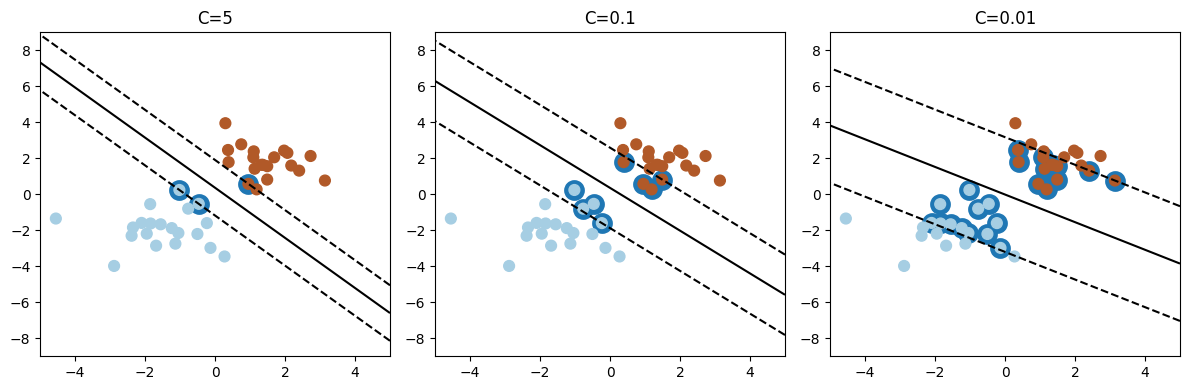

In [7]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [-1] * 20 + [1] * 20

plt.figure(figsize=(12, 4))

plotnum = 1
for name, penalty in (('C=5', 5), ('C=0.1', 0.1), ('C=0.01', 0.01)): #오분류를 줄이기 위해 C를 조정
    clf = SVC(kernel='linear', C=penalty).fit(X, Y)
    xx = np.linspace(-5, 5)

    x_jin = -5
    x_jax = 5
    y_jin = -9
    y_jax = 9
    XX, YY = np.mgrid[x_jin:x_jax:200j, y_jin:y_jax:200j]

    levels = [-1, 0, 1]
    linestyles = ['dashed', 'solid', 'dashed']
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    plt.subplot(1, 3, plotnum)
    plt.contour(XX, YY, Z, levels, colors='k', linestyles=linestyles)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=120, linewidth=4)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=60, linewidth=1, cmap=plt.cm.Paired)
    plt.xlim(x_jin, x_jax)
    plt.ylim(y_jin, y_jax)
    plt.title(name)

    plotnum += 1

plt.tight_layout()
plt.show()

#C=0.1일 때는 오분류를 다소 허용, 마진을 넓게 잡음
#C=10 이상이면 거의 모든 포인트를 맞추기 위해 마진을 좁히게 됨

### 3) With Kernel

Kernel trick을 사용하면 고차원에서 내적을 계산하여 선형 결정 경계를 찾는 과정을 간단한 연산으로 수행 가능함.

원래 공간에서 비선형 결정 경계를 찾는 것과 같은 효과를 쉽게 얻을 수 있음.

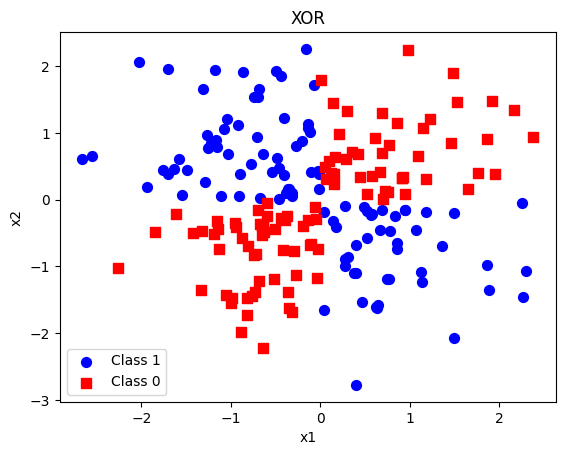

In [8]:
# 대표적인 non-linearseparable problem인 XOR 문제를 시각화
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            c='b', marker='o', label='Class 1', s=50)
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1],
            c='r', marker='s', label='Class 0', s=50)
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR")
plt.show()

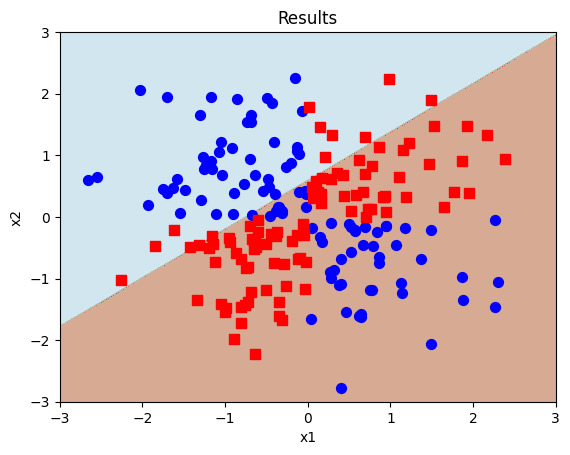

In [9]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(
        np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap='Paired_r', alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b',
                marker='o', label='Class 1', s=50)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r',
                marker='s', label='Class 0', s=50)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

from sklearn.svm import SVC

svc = SVC(kernel="linear").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, "Results")
plt.show()

In [10]:
from sklearn.preprocessing import FunctionTransformer

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1], X[:, 1]**2]).T #

FunctionTransformer(basis).fit_transform(X)

array([[ 5.56712954e-02,  5.33836138e-01,  2.55949696e+00],
       [ 1.04297611e+00, -3.47917855e-01,  5.80295334e-02],
       [ 1.75408860e-02,  5.57647977e-01,  8.86418357e+00],
       [ 1.10231433e+00,  3.19433346e+00,  4.62833784e+00],
       [ 4.42352954e+00,  4.72751681e+00,  2.52619712e+00],
       [ 3.44457427e+00,  1.43237856e+00,  2.97817405e-01],
       [ 1.53502752e+00,  3.29112074e+00,  3.52810474e+00],
       [ 2.42156164e+00,  3.66709911e+00,  2.77664125e+00],
       [ 2.55955984e-01,  1.57774716e+00,  4.86272297e+00],
       [ 2.84574058e+00,  6.80896636e+00,  8.14586249e+00],
       [ 2.07297163e+01,  8.66921515e+00,  1.81274289e+00],
       [ 1.28950515e+00,  4.40372433e+00,  7.51946900e+00],
       [ 7.27675572e-02, -1.31780820e+00,  1.19326422e+01],
       [ 3.81905977e+00,  6.04475240e+00,  4.78377319e+00],
       [ 2.18295263e-01,  3.50621178e-01,  2.81580115e-01],
       [ 3.40421900e+00,  4.23185790e+00,  2.63035681e+00],
       [ 8.33930652e+00,  1.62573569e+01

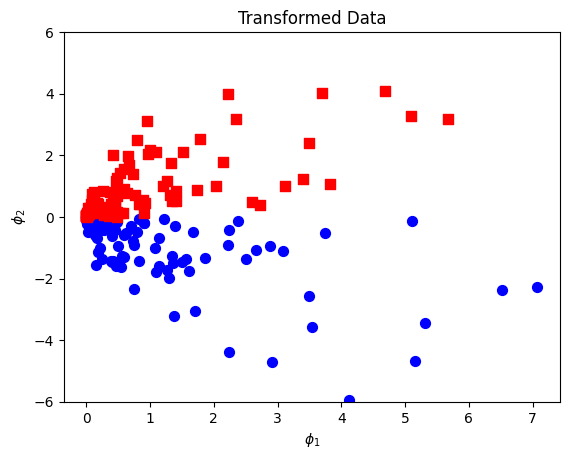

In [11]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor == 1, 0], X_xor2[y_xor == 1, 1], c="b", marker='o', s=50)
plt.scatter(X_xor2[y_xor == 0, 0], X_xor2[y_xor == 0, 1], c="r", marker='s', s=50)
plt.ylim(-6, 6)
plt.title("Transformed Data")
plt.xlabel(r"$\phi_1$")
plt.ylabel(r"$\phi_2$")
plt.show()

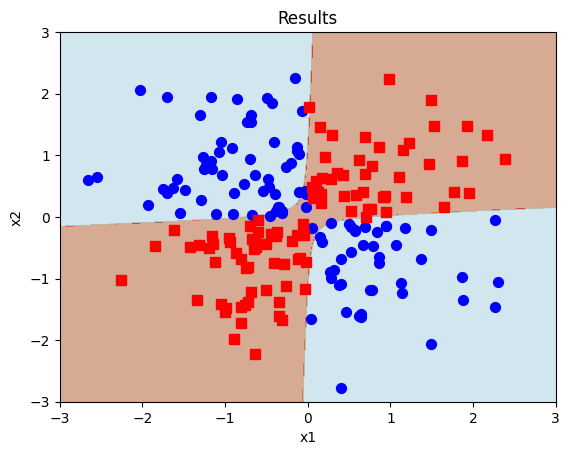

In [12]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([("basis", FunctionTransformer(basis)),
                       ("svc", SVC(kernel="linear"))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, "Results")
plt.show()

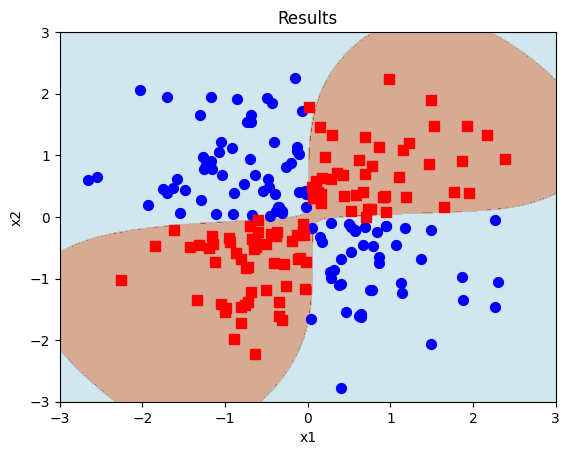

In [13]:
from sklearn.pipeline import Pipeline

kernelmodel = SVC(kernel="rbf").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, kernelmodel, "Results")
plt.show()

## SVM with Iris

RBF kernel

$K\left(\mathbf{x}_1, \mathbf{x}_2\right)=\exp \left(-\gamma \cdot\left\|\mathbf{x}_1-\mathbf{x}_2\right\|^2\right)$

Polynomial kernel

$K\left(\mathbf{x}_1, \mathbf{x}_2\right)=\left(\gamma \cdot \mathbf{x}_1^{\top} \mathbf{x}_2+r\right)^d$

Sigmoid kernel

$K\left(\mathbf{x}_1, \mathbf{x}_2\right)=\tanh \left(\gamma \cdot \mathbf{x}_1^{\top} \mathbf{x}_2+r\right)$

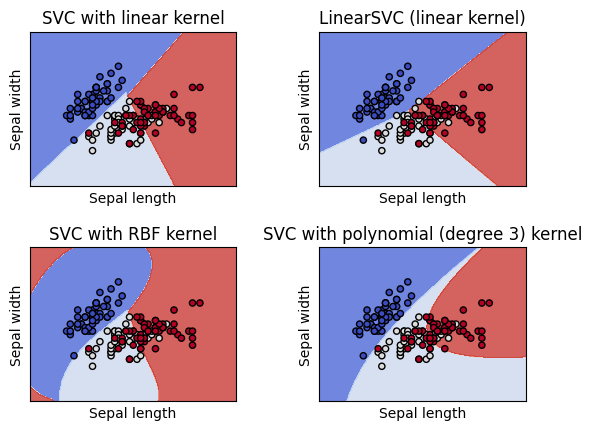

In [ ]:
#ref: https://todayisbetterthanyesterday.tistory.com/32

import matplotlib.pyplot as plt
from sklearn import svm, datasets

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.

fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

# Exercise

In [15]:
from sklearn import datasets

cancer_data = datasets.load_breast_cancer()
print(cancer_data.data)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [16]:
cancer_data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [17]:
print(cancer_data.data.shape)
#target set
print(cancer_data.target)


(569, 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, test_size=0.4,random_state=109)

In [ ]:
'''# 2차원 PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 시각화
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
markers = ['o', '^']
for idx, target in enumerate(cancer_data.target_names):
    plt.scatter(
        X_pca[y_train == idx, 0], X_pca[y_train == idx, 1],
        c=colors[idx], marker=markers[idx],
        label=target, alpha=0.5
    )
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.title("Breast Cancer Dataset: PCA Projection", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()'''

In [ ]:
## To-do
# X_train, y_train으로 학습시키고 X_test 예측해서 pred에 저장

pred = ???

# 파라미터 바꿔가며 아래 metrics score로 성능 변화 관찰해보기

In [22]:
from sklearn import metrics
#accuracy
print("acuracy:", metrics.accuracy_score(y_test,y_pred=pred))
#precision score
print("precision:", metrics.precision_score(y_test,y_pred=pred))
#recall score
print("recall" , metrics.recall_score(y_test,y_pred=pred))
print(metrics.classification_report(y_test, y_pred=pred))
#suport

acuracy: 0.6052631578947368
precision: 0.6052631578947368
recall 1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.61      1.00      0.75       138

    accuracy                           0.61       228
   macro avg       0.30      0.50      0.38       228
weighted avg       0.37      0.61      0.46       228



d:\anaconda3\envs\reflective_allocator\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\reflective_allocator\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\reflective_allocator\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)